In [1]:
import numpy as np   
import matplotlib.pyplot as plt

import emcee
import corner
from chainconsumer import ChainConsumer
from scipy.optimize import minimize

# 1. Preparation

$A=2.0$, $B=2.0$ $\alpha_B=0.3$

In [2]:

data = np.loadtxt("/home/s/Sijin.Chen/course/from_data_to_insights/tutorial08/xi_measurement_tutorial8.dat")
print(data.shape)
theta = data[:, 0]
xi = data[:, 1]
err = data[:, 2]
err_cov = np.diag(err)

(20, 3)


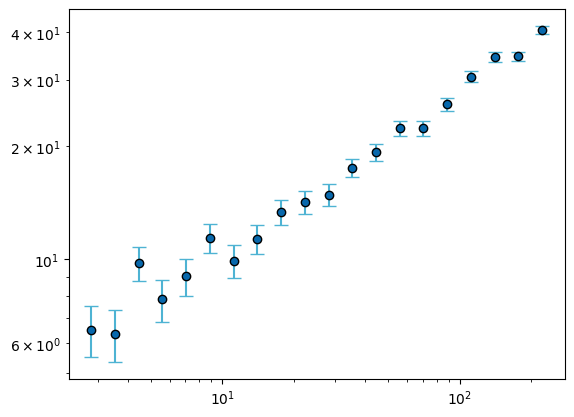

In [3]:
plt.errorbar(theta, xi, yerr=err, fmt='o', mfc='#0868ac', mec='black', ecolor='#4eb3d3', capsize=5)
plt.yscale('log')
plt.xscale("log")

In [4]:
A_s = np.array([2., 2., 3. ])
B_s = np.array([2., 2., 0. ])
alpha_B_s = np.array([0.3, 0.4, 0.3])


In [5]:
def model(theta, A, B, alpha_B):
    return A*theta**0.5 + B * theta**(alpha_B)



Best-fit parameters:
A = 2.6195245073050053
B = 2.7544473625567805
alpha_B = -0.11903507814001328


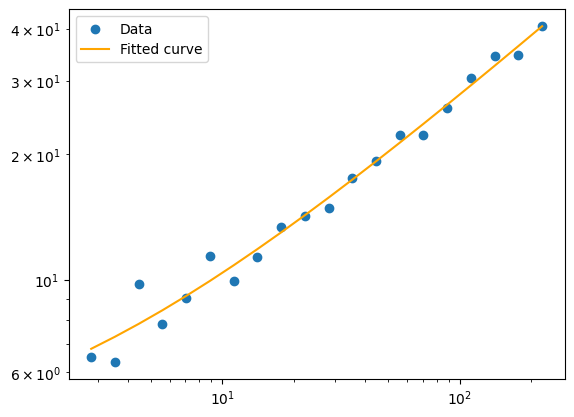

In [6]:


def objective(params, x, y):
    A, B, alpha_B = params
    y_pred = model(x, A, B, alpha_B)
    return np.sum((y - y_pred)**2)


initial_guesses = [1.0, 1.0, 1.0]

result = minimize(lambda params: objective(params, theta, xi), initial_guesses)

A_fit, B_fit, alpha_B_fit = result.x

print(f"Best-fit parameters:\nA = {A_fit}\nB = {B_fit}\nalpha_B = {alpha_B_fit}")

plt.scatter(theta, xi, label='Data')
plt.plot(theta, model(theta, A_fit, B_fit, alpha_B_fit), label='Fitted curve', color='orange')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.show()

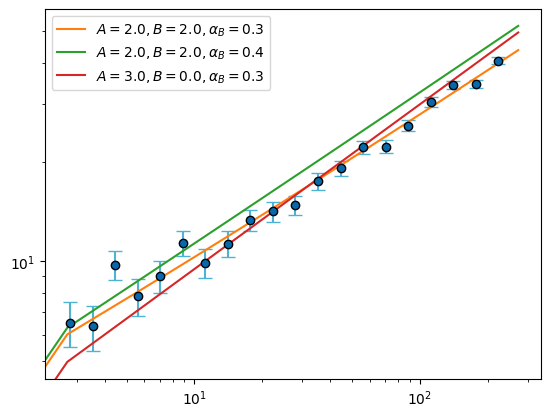

In [7]:
theta_range = np.linspace(0, np.max(theta)+50, 101)

aa = model(theta_range, A_s[0], B_s[0], alpha_B_s[0])

plt.errorbar(theta, xi, yerr=err, fmt='o', mfc='#0868ac', mec='black', ecolor='#4eb3d3', capsize=5)
plt.yscale('log')
plt.xscale("log")

plt.plot(theta_range, model(theta_range, A_s[0], B_s[0], alpha_B_s[0]), label = fr"$A={A_s[0]}, B={B_s[0]}, \alpha_B={alpha_B_s[0]}$")
plt.plot(theta_range, model(theta_range, A_s[1], B_s[1], alpha_B_s[1]), label = fr"$A={A_s[1]}, B={B_s[1]}, \alpha_B={alpha_B_s[1]}$")
plt.plot(theta_range, model(theta_range, A_s[2], B_s[2], alpha_B_s[2]), label = fr"$A={A_s[2]}, B={B_s[2]}, \alpha_B={alpha_B_s[2]}$")

plt.legend()



In [8]:
a = np.arange(5)
b, c, d, e, f = a 
print(b, c ,d ,e)

0 1 2 3


# 2. Sampling a chain with a nuisance model

In [9]:
def log_prior(params):
    A, B, alpha_B = params
    if -10.0 <= A <= 10.0 and -10.0 <= B <= 10.0 and 0.0 <= alpha_B <=0.4 :
        return 0.0
    return -np.inf

In [10]:
def log_likelihood(params, theta, xi, err_cov):
    A, B, alpha_B = params
    xi_model = A*theta **0.5 + B*theta **alpha_B
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result

In [11]:
def log_posterior(params, theta, xi, err_cov):
    A, B, alpha_B = params
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, theta, xi, err_cov)


In [12]:
nwalkers = 100
ndim = 3
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))



sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(theta, xi, err_cov)
)
sampler.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/s/Sijin.Chen/course/from_data_to_insights/tutorial08/venv_corner/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:49<00:00, 100.24it/s]


In [13]:
samples = sampler.get_chain()
print(samples.shape)
flat_samples = sampler.get_chain(discard=4000, flat=True)
print(flat_samples.shape)

(5000, 100, 3)
(100000, 3)


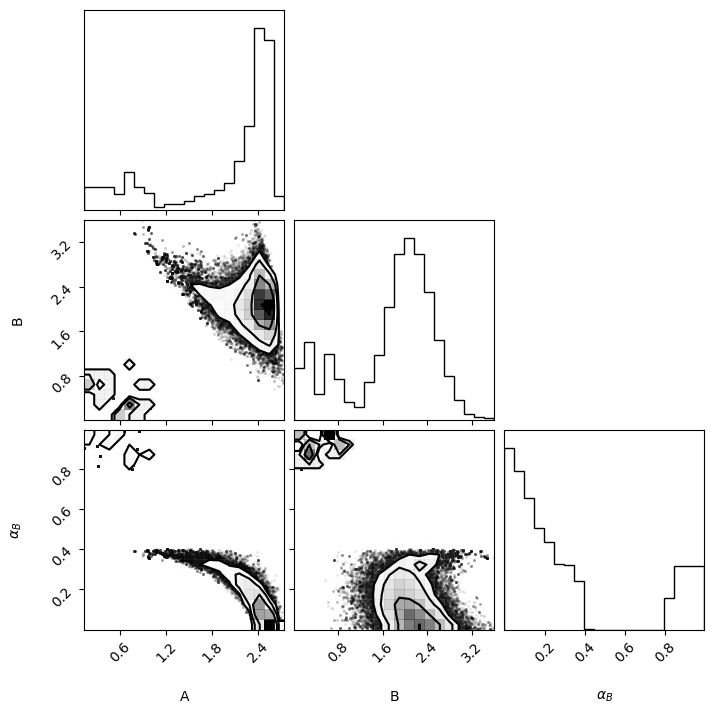

In [14]:

fig = corner.corner(
    flat_samples, labels=["A", "B", r"$\alpha_B$"]
);

In [58]:
def log_prior_wide(params):
    A, B, alpha_B = params
    if -10.0 <= A <= 10.0 and -10.0 <= B <= 10.0 and -2.0 <= alpha_B <=2.0 :
        return 0.0
    return -np.inf

In [59]:
def log_posterior_wide(params, theta, xi, err_cov):
    A, B, alpha_B = params
    lp = log_prior_wide(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, theta, xi, err_cov)

In [68]:
nwalkers = 50
ndim = 3
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))



sampler_wide = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_wide, args=(theta, xi, err_cov)
)
sampler_wide.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:36<00:00, 138.28it/s]


In [69]:
samples_wide = sampler_wide.get_chain()
print(samples_wide.shape)
flat_samples_wide = sampler_wide.get_chain(discard=4000, flat=True)
print(flat_samples_wide.shape)

(5000, 50, 3)
(50000, 3)


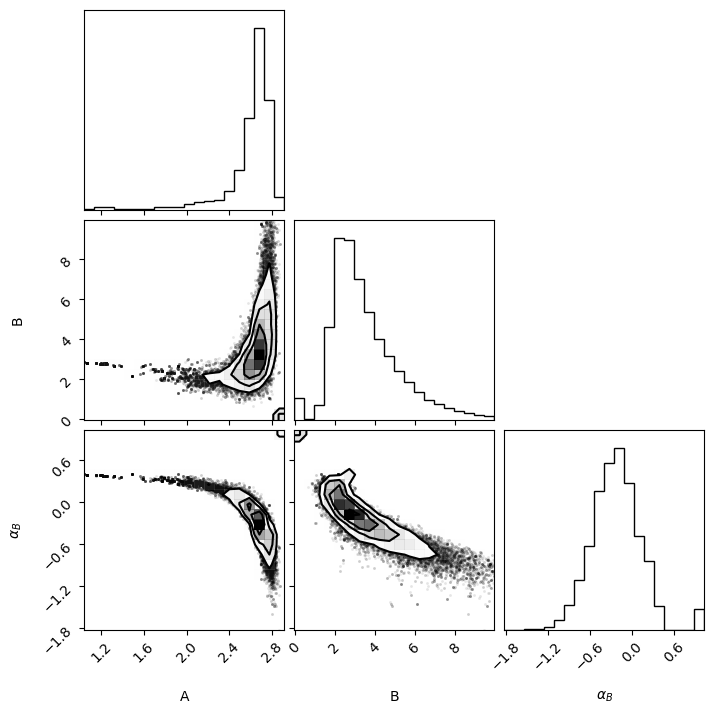

In [70]:
fig = corner.corner(
    flat_samples_wide, labels=["A", "B", r"$\alpha_B$"]
);

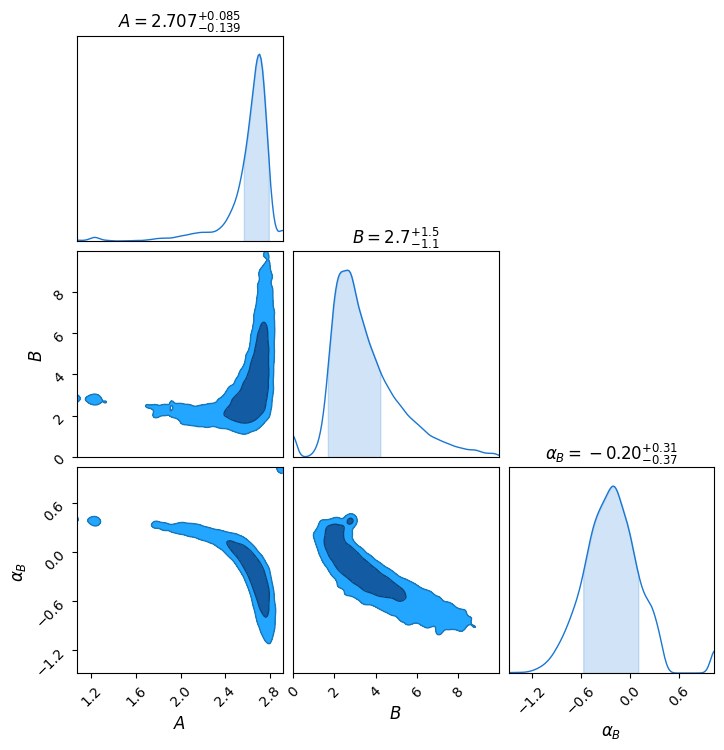

In [71]:
fig = ChainConsumer().add_chain(flat_samples_wide, parameters=['$A$', '$B$', r'$ \alpha_B $']).plotter.plot()

fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

# 3. Marginalizing over the nuisance with a covariance

In [21]:
print(flat_samples.shape)


(100000, 3)


In [22]:
cov_B = np.cov(flat_samples[:, 1])
cov_alpha_B = np.cov(flat_samples[:, 2])
cov_B_alpha_B = np.cov(flat_samples[:, 1:], rowvar=False)
print(cov_B_alpha_B)
print(cov_B)
print(cov_alpha_B)
print(np.cov(flat_samples, rowvar=False))

[[ 0.59992706 -0.2084795 ]
 [-0.2084795   0.10394735]]
0.5999270601953712
0.10394734969016074
[[ 0.5851914   0.43656348 -0.2396894 ]
 [ 0.43656348  0.59992706 -0.2084795 ]
 [-0.2396894  -0.2084795   0.10394735]]


In [23]:
print(flat_samples.shape)

(100000, 3)


In [24]:
def model_3(theta, A):
    return A*theta**0.5



In [25]:
aaa = np.zeros(shape=(flat_samples.shape[0], 20))
bbb = np.zeros(shape=(flat_samples.shape[0], 20))


for i in range(flat_samples.shape[0]):
    aaa[i] = model_3(theta, flat_samples[i, 0])
    bbb[i] = model(theta, flat_samples[i, 0], flat_samples[i, 1], flat_samples[i, 2])

In [26]:
# diff = aaa - bbb 
# print(np.cov(diff))
print(aaa.shape)
print(bbb.shape)

(100000, 20)
(100000, 20)


In [27]:
diff = aaa - bbb 
cov_comb = np.cov(diff, rowvar=False)


In [28]:
err_cov_new = err_cov + cov_comb

In [29]:
def log_prior_3(params):
    A = params
    if -10.0 <= A <= 10.0 :
        return 0.0
    return -np.inf

In [30]:
def log_likelihood_3(params, theta, xi, err_cov):
    A = params
    xi_model = A*theta **0.5 
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result

In [31]:
def log_posterior_3(params, theta, xi, err_cov):
    A = params
    lp = log_prior_3(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_3(params, theta, xi, err_cov)

In [32]:
nwalkers = 100
ndim = 1
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))



sampler_3 = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_3, args=(theta, xi, err_cov_new)
)
sampler_3.run_mcmc(initial, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:52<00:00, 95.34it/s] 


In [33]:
flat_samples_wide_3 = sampler_3.get_chain(discard=4000, flat=True)
print(flat_samples_wide_3.shape)

(100000, 1)


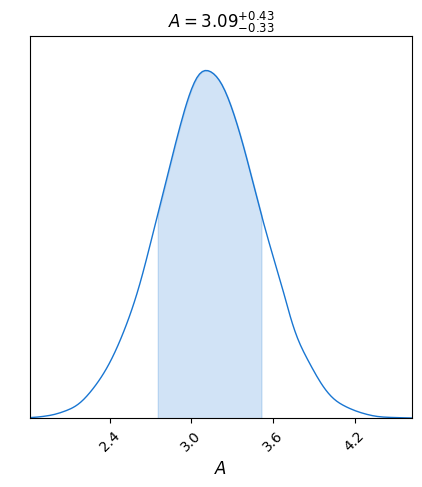

In [34]:
fig = ChainConsumer().add_chain(flat_samples_wide_3, parameters=['$A$']).plotter.plot()

fig.set_size_inches(3 + fig.get_size_inches())  # Resize fig for doco. You don't need this.

In [35]:
A_pos_max = 2.68

In [36]:
def model_B_alpha_B(x, B, alpha_B):
    return A_pos_max * x**0.5 + B*x**alpha_B

In [37]:
def log_prior_B_alpha_B(params):
    B, alpha_B = params
    if -10.0 <= B <= 10.0 and 0.0 <= alpha_B <=0.4 :
        return 0.0
    return -np.inf




def log_likelihood_B_alpha_B(params, theta, xi, err_cov):
    B, alpha_B = params
    xi_model = A_pos_max*theta **0.5 + B*theta **alpha_B
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result




def log_posterior_B_alpha_B(params, theta, xi, err_cov):
    B, alpha_B = params
    lp = log_prior_B_alpha_B(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_B_alpha_B(params, theta, xi, err_cov)

In [38]:
nwalkers = 100
ndim = 2
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))
print(initial.shape)


sampler_B_alpha_B = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_B_alpha_B, args=(theta, xi, err_cov)
)
sampler_B_alpha_B.run_mcmc(initial, 5000, progress=True);

(100, 2)


  0%|          | 0/5000 [00:00<?, ?it/s]/home/s/Sijin.Chen/course/from_data_to_insights/tutorial08/venv_corner/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:45<00:00, 109.20it/s]


In [39]:
flat_samples_B_alpha_B = sampler_B_alpha_B.get_chain(discard=4000, flat=True)
print(flat_samples_B_alpha_B.shape)

(100000, 2)


In [40]:
B_theta_alpha_B = np.zeros(shape=(100000, 20))

for i in range(100000):
    B_theta_alpha_B[i] = flat_samples_B_alpha_B[i, 0]*theta**flat_samples_B_alpha_B[i, 1]

In [41]:
err_B_alpha_B = np.cov(B_theta_alpha_B, rowvar=False)
print(err_B_alpha_B.shape)

(20, 20)


In [42]:
err_total = err_cov + err_B_alpha_B

In [43]:
# def log_prior_A(params):
#     A = params
#     if -10.0 <= A <= 10.0 :
#         return 0.0
#     return -np.inf




# def log_likelihood_A(params, theta, xi, err_cov):
#     A = params
#     xi_model = A*theta **0.5
#     diff = xi_model - xi  
#     result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
#     return result




# def log_posterior_A(params, theta, xi, err_cov):
#     A = params
#     lp = log_prior_A(params)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + log_likelihood_A(params, theta, xi, err_cov)

In [44]:
# nwalkers = 100
# ndim = 1
# initial = np.random.uniform(0, 1, size=(nwalkers, ndim))
# print(initial.shape)


# sampler_A = emcee.EnsembleSampler(
#     nwalkers, ndim, log_posterior_A, args=(theta, xi, err_total)
# )
# sampler_A.run_mcmc(initial, 5000, progress=True);

(100, 1)


100%|██████████| 5000/5000 [01:15<00:00, 66.34it/s] 


(100000, 1)


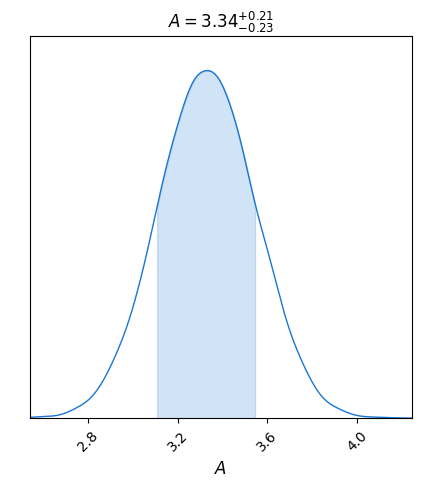

In [45]:
# flat_samples_A = sampler_A.get_chain(discard=4000, flat=True)
# print(flat_samples_A.shape)

# fig = ChainConsumer().add_chain(flat_samples_A, parameters=['$A$']).plotter.plot()

# fig.set_size_inches(3 + fig.get_size_inches()) 

In [75]:
# Bsample = np.random.uniform(-10, 10, 10000)
# alpha_B_sample = np.random.uniform(0., 0.4, 10000)

# nuisance_sample = Bsample * np.power.outer(theta, alpha_B_sample)

# print(nuisance_sample.shape)
# M = np.cov(nuisance_sample)
# print(M.shape)

# cov_total = M + err_cov

(20, 10000)
(20, 20)


In [76]:
def model_A(theta, A):
    return A*theta**0.5

In [77]:
def log_prior_A(params):
    A = params
    if -10.0 <= A <= 10.0 :
        return 0.0
    return -np.inf




def log_likelihood_A(params, theta, xi, err_cov):
    A = params
    xi_model = A*theta **0.5
    diff = xi_model - xi  
    result = -0.5 * diff.T @ np.linalg.inv(err_cov) @ diff 
    return result




def log_posterior_A(params, theta, xi, err_cov):
    A = params
    lp = log_prior_A(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_A(params, theta, xi, err_cov)

In [79]:
# M = sigma_B * np.out(df_dB, df_dB)    <-- v*v.T   
# M += sigma_alpha_B * np.out(df_dalpha, df_dalpha)    <-- v*v.T   
nwalkers = 100
ndim = 1
initial = np.random.uniform(0, 1, size=(nwalkers, ndim))
print(initial.shape)


sampler_A = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_A, args=(theta, xi, err_total)
)
sampler_A.run_mcmc(initial, 5000, progress=True);



(100, 1)


100%|██████████| 5000/5000 [00:53<00:00, 93.84it/s] 


(100000, 1)


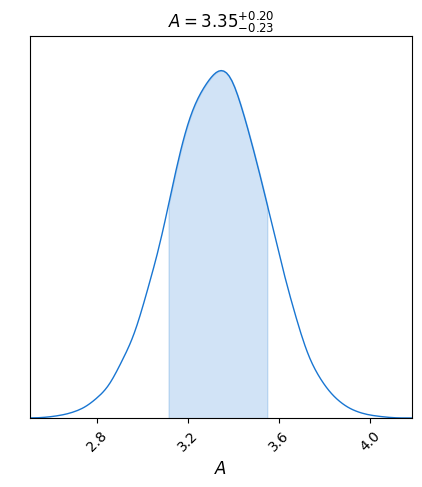

In [80]:
flat_samples_A = sampler_A.get_chain(discard=4000, flat=True)
print(flat_samples_A.shape)

fig = ChainConsumer().add_chain(flat_samples_A, parameters=['$A$']).plotter.plot()

fig.set_size_inches(3 + fig.get_size_inches()) 